In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('white')

In [2]:
from nbsupport import morphology as morph
from nbsupport.util import sort_matrix

# Read sample definition.
samples = pd.read_csv('../data/raw/samples.txt', sep='\t')

# Define morphology annotation based on sample definitions.
morphology = (
    pd.DataFrame({
        'sample': samples['sample'],
        'Classical ILC': samples['pathology_type'].str.startswith('classical ILC'),
        'Non-classical ILC': samples['pathology_type'].str.contains('nonclassical'),
        'EMT': samples['pathology_type'].str.contains('EMT'),
        'Squamous': samples['pathology_type'].str.contains('squamous')
    }, columns=['sample', 'Classical ILC', 'EMT', 'Squamous', 'Non-classical ILC'])
    .set_index('sample')
    .fillna(False))

# Sort matrix values.
morphology = sort_matrix(morphology, sort_columns=False)

# Write morphology matrix for use in later notebooks.
morphology.to_csv('../data/processed/morphology.txt', sep='\t', index=True)

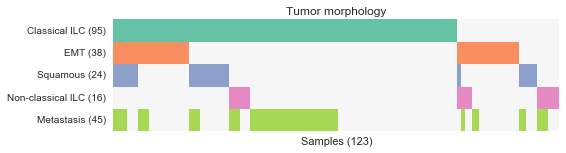

In [3]:
# Read mouse metastases.
metastases = pd.read_csv('../data/raw/metastases.txt', sep='\t')
metastases = metastases.ix[metastases['mouse'].isin(samples['mouse'])]

# Merge morphology with metastasis data.
met_samples = (
    samples.get(['mouse', 'sample'])
           .assign(Metastasis=lambda df: df['mouse'].isin(set(metastases['mouse'])))
           .drop('mouse', axis=1)
           .set_index('sample'))

merged = pd.concat([morphology, met_samples], axis=1)

# Plot as heatmap.
fig, ax = plt.subplots(figsize=(8, 2))
morph.plot_morphology(merged, palette=sns.color_palette('Set2'),
                      ax=ax, sort_columns=False)
ax.set_xlabel('Samples ({})'.format(merged.shape[0]))

# Draw again for paper.
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(4.5, 1.4))
    morph.plot_morphology(merged, sns.color_palette('Set2'),
                          sort_columns=False, ax=ax)
    ax.set_xlabel('Samples ({})'.format(merged.shape[0]))

fig.savefig('../reports/figures/fig_1_morphology.pdf', bbox_inches='tight')
plt.close(fig)

In [24]:
from nbsupport.enrichment import associations as nb_assoc

# Subset the merged matrix to mice that have a single tumor or
# multiple tumors with the same morphology.
mouse_path_count = samples.groupby('mouse')['pathology_type'].nunique()

unique_mice = set(mouse_path_count.ix[mouse_path_count == 1].index)
unique_samples = set(samples.ix[samples['mouse'].isin(unique_mice), 'sample'])

merged_unique = merged.ix[unique_samples]

# Test for associations between morphology and metastasis.
nb_assoc.test_associations(merged_unique[merged_unique.columns[0:4]],
                           merged_unique[['Metastasis']],
                           alternative='greater')

,a,b,p_value,p_value_corr
0,Classical ILC,Metastasis,0.131605,0.526420
1,EMT,Metastasis,0.991968,0.991968
2,Squamous,Metastasis,0.814093,0.991968
3,Non-classical ILC,Metastasis,0.403166,0.806332


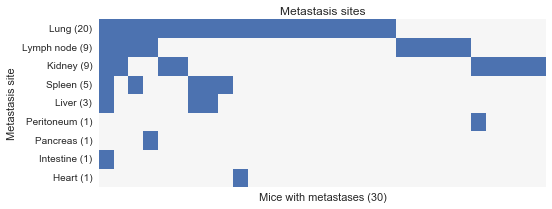

In [4]:
# Pivot to matrix of mice-by-sites.
metastases_mat = pd.pivot_table(
    metastases, index='mouse', columns='metastasis_site',
    aggfunc=len, fill_value=0)

# Plot metastasis matrix.
fig, ax = plt.subplots(figsize=(8, 3))
morph.plot_metastases(metastases_mat, ax=ax)
ax.set_xlabel('Mice with metastases ({})'
              .format(metastases_mat.shape[0]))
ax.set_ylabel('Metastasis site')

# Draw again for paper.
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(3, 1.5))
    
    morph.plot_metastases(metastases_mat, ax=ax)
    ax.set_xlabel('Mice with metastases ({})'
              .format(metastases_mat.shape[0]))
    ax.set_ylabel('Metastasis site')

    fig.savefig('../reports/figures/fig_1_metastases.pdf', bbox_inches='tight')
    plt.close(fig)